In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cigarette-butt/images/test_labels.csv
/kaggle/input/cigarette-butt/images/train_labels.csv
/kaggle/input/cigarette-butt/images/test/frame1416.jpg
/kaggle/input/cigarette-butt/images/test/frame5112.jpg
/kaggle/input/cigarette-butt/images/test/frame198.xml
/kaggle/input/cigarette-butt/images/test/IMG_20200319_190719.xml
/kaggle/input/cigarette-butt/images/test/frame2130.xml
/kaggle/input/cigarette-butt/images/test/frame12421.xml
/kaggle/input/cigarette-butt/images/test/IMG_20200319_190608.xml
/kaggle/input/cigarette-butt/images/test/frame9456.jpg
/kaggle/input/cigarette-butt/images/test/frame9660.jpg
/kaggle/input/cigarette-butt/images/test/frame7848.xml
/kaggle/input/cigarette-butt/images/test/frame7590.xml
/kaggle/input/cigarette-butt/images/test/frame9738.jpg
/kaggle/input/cigarette-butt/images/test/frame1614.jpg
/kaggle/input/cigarette-butt/images/test/frame7164.jpg
/kaggle/input/cigarette-butt/images/test/frame8994.jpg
/kaggle/input/cigarette-butt/images/test/frame9558

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import mnist
from tensorflow import keras



warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline



In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/cigarette-butt/images/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/cigarette-butt/images/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 2042 files belonging to 2 classes.
Using 1634 files for training.
Found 2042 files belonging to 2 classes.
Using 408 files for validation.


2021-11-30 04:12:32.666574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 04:12:32.793721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 04:12:32.794484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 04:12:32.797601: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2021-11-30 04:12:41.734725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


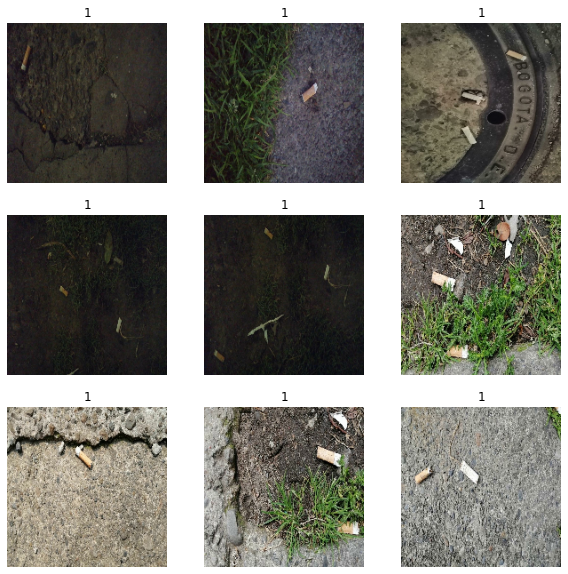

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

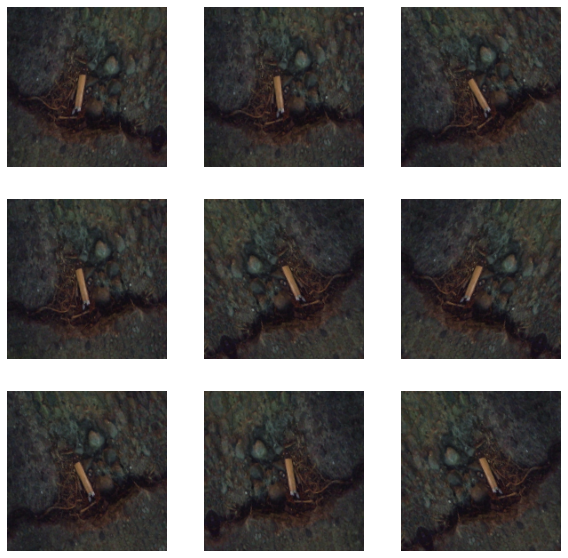

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
augmented_train_ds = train_ds.map(lambda x, y:
                                  (data_augmentation(x, training=True), y))

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

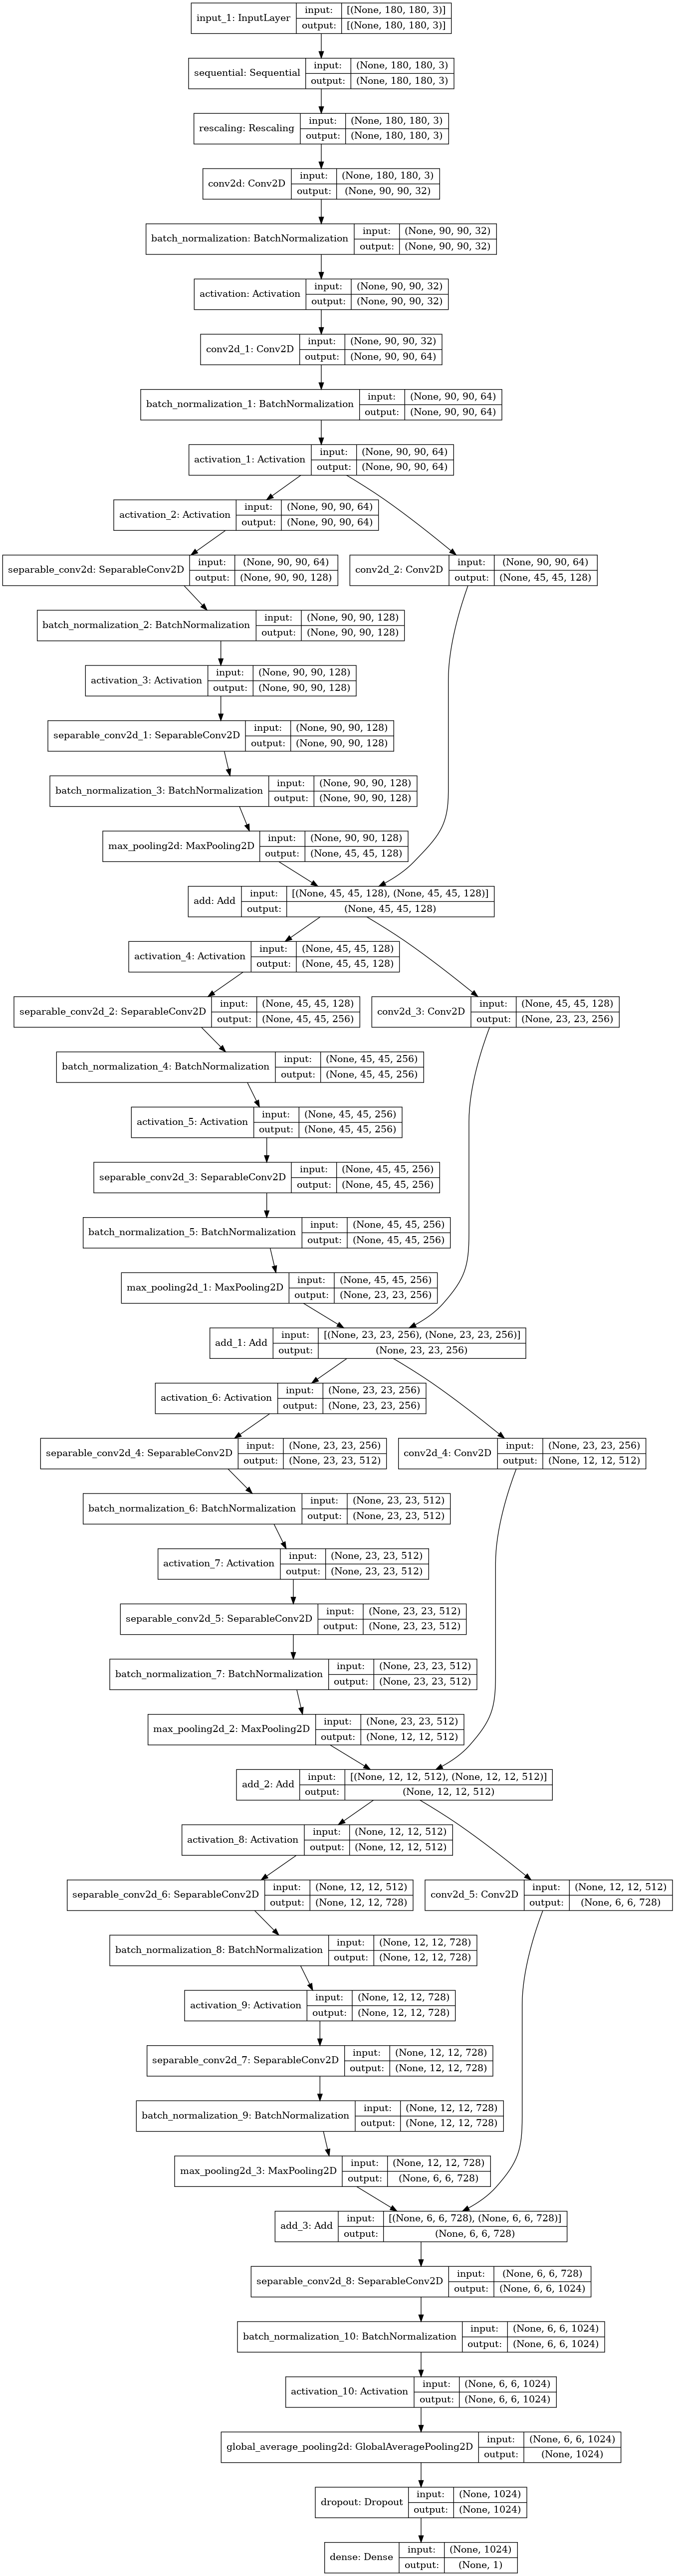

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)
    
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x #Set aside residual
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        #Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)
    
    
    

In [10]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)



Epoch 1/50


2021-11-30 04:18:26.263081: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


52/52 [==============================] - 24s 261ms/step - loss: 0.5972 - accuracy: 0.7736 - val_loss: 0.5633 - val_accuracy: 0.8064


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
52/52 [==============================] - 12s 210ms/step - loss: 0.5486 - accuracy: 0.7876 - val_loss: 0.5373 - val_accuracy: 0.8064
Epoch 3/50
52/52 [==============================] - 12s 220ms/step - loss: 0.5508 - accuracy: 0.7882 - val_loss: 0.4927 - val_accuracy: 0.8064
Epoch 4/50
52/52 [==============================] - 12s 209ms/step - loss: 0.5447 - accuracy: 0.7980 - val_loss: 0.4933 - val_accuracy: 0.8064
Epoch 5/50
52/52 [==============================] - 12s 208ms/step - loss: 0.5314 - accuracy: 0.7944 - val_loss: 0.4935 - val_accuracy: 0.8064
Epoch 6/50
52/52 [==============================] - 12s 215ms/step - loss: 0.5239 - accuracy: 0.7987 - val_loss: 0.4928 - val_accuracy: 0.8064
Epoch 7/50
52/52 [==============================] - 12s 207ms/step - loss: 0.5279 - accuracy: 0.7987 - val_loss: 0.5086 - val_accuracy: 0.8064
Epoch 8/50
52/52 [==============================] - 12s 211ms/step - loss: 0.5237 - accuracy: 0.7987 - val_loss: 0.4960 - val_accuracy: 0.8064

In [11]:
pwd
base_dir = "/kaggle/input/cigarette-butt/images/"

'/kaggle/working'

In [18]:
img = keras.preprocessing.image.load_img(
    "/kaggle/input/cigarette-butt/images/train/frame6282.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent something else and %.2f percent cig_butt."
    % (100 * (1 - score), 100 * score)
)

This image is 7.58 percent something else and 92.42 percent cig_butt.


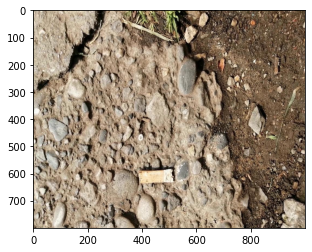

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread("/kaggle/input/cigarette-butt/images/train/frame6282.jpg")
imgplt = plt.imshow(img)

In [21]:
model.save("/kaggle/working")

2021-11-30 04:48:40.697889: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
model.save("my_model")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
!ls my_model

assets	keras_metadata.pb  saved_model.pb  variables


In [26]:
os.listdir('/kaggle/working')

['__notebook_source__.ipynb',
 'save_at_30.h5',
 'save_at_28.h5',
 'save_at_24.h5',
 'save_at_35.h5',
 'save_at_50.h5',
 'save_at_49.h5',
 'save_at_13.h5',
 'save_at_14.h5',
 'save_at_19.h5',
 'save_at_48.h5',
 'save_at_37.h5',
 'save_at_7.h5',
 'model.png',
 'save_at_9.h5',
 'save_at_15.h5',
 'keras_metadata.pb',
 'save_at_34.h5',
 'save_at_29.h5',
 'save_at_38.h5',
 'save_at_5.h5',
 'save_at_26.h5',
 'save_at_42.h5',
 'save_at_21.h5',
 'save_at_6.h5',
 'save_at_45.h5',
 'save_at_12.h5',
 'saved_model.pb',
 'my_model',
 'save_at_10.h5',
 'save_at_8.h5',
 'save_at_4.h5',
 'save_at_32.h5',
 'save_at_39.h5',
 'save_at_16.h5',
 'save_at_46.h5',
 'save_at_18.h5',
 'save_at_43.h5',
 'save_at_17.h5',
 'save_at_25.h5',
 'save_at_23.h5',
 'save_at_11.h5',
 'save_at_31.h5',
 'save_at_33.h5',
 'variables',
 'save_at_27.h5',
 'save_at_36.h5',
 'save_at_22.h5',
 'save_at_47.h5',
 'save_at_20.h5',
 'save_at_44.h5',
 'save_at_2.h5',
 'save_at_41.h5',
 'save_at_40.h5',
 'save_at_3.h5',
 'save_at_1.h5

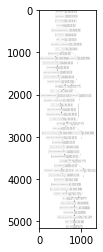

In [24]:
img = mpimg.imread("/kaggle/working/model.png")
imgplot = plt.imshow(img)


In [22]:
os.listdir("/kaggle/working")

['__notebook_source__.ipynb',
 'save_at_30.h5',
 'save_at_28.h5',
 'save_at_24.h5',
 'save_at_35.h5',
 'save_at_50.h5',
 'save_at_49.h5',
 'save_at_13.h5',
 'save_at_14.h5',
 'save_at_19.h5',
 'save_at_48.h5',
 'save_at_37.h5',
 'save_at_7.h5',
 'model.png',
 'save_at_9.h5',
 'save_at_15.h5',
 'keras_metadata.pb',
 'save_at_34.h5',
 'save_at_29.h5',
 'save_at_38.h5',
 'save_at_5.h5',
 'save_at_26.h5',
 'save_at_42.h5',
 'save_at_21.h5',
 'save_at_6.h5',
 'save_at_45.h5',
 'save_at_12.h5',
 'saved_model.pb',
 'save_at_10.h5',
 'save_at_8.h5',
 'save_at_4.h5',
 'save_at_32.h5',
 'save_at_39.h5',
 'save_at_16.h5',
 'save_at_46.h5',
 'save_at_18.h5',
 'save_at_43.h5',
 'save_at_17.h5',
 'save_at_25.h5',
 'save_at_23.h5',
 'save_at_11.h5',
 'save_at_31.h5',
 'save_at_33.h5',
 'variables',
 'save_at_27.h5',
 'save_at_36.h5',
 'save_at_22.h5',
 'save_at_47.h5',
 'save_at_20.h5',
 'save_at_44.h5',
 'save_at_2.h5',
 'save_at_41.h5',
 'save_at_40.h5',
 'save_at_3.h5',
 'save_at_1.h5',
 'assets']